In [4]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
from filtered_point_process.model import Model
from filtered_point_process.point_processes.filtered_point_process import FilteredPointProcess
from spectral_connectivity import Multitaper, Connectivity

# --------------------- Style ---------------------
plt.rcParams.update({
    'axes.linewidth': 1.5,
    'grid.alpha': 0.6,
    'grid.linestyle': '--',
    'font.size': 22,
    'axes.titlesize': 26,
    'axes.labelsize': 24,
    'legend.fontsize': 18,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'savefig.dpi': 500
})
kernel_h1_color = 'tab:blue'
kernel_h2_color = 'tab:orange'
mt_h1_color = 'tab:purple'
mt_h2_color = 'tab:green'
theory_h1_color = 'k'
theory_h2_color = 'dimgray'

## Action potential kernel scaling example

In [5]:
# --------------------- Sim params ---------------------
fs = 10_000       # Hz
T = 5.0           # s
lambda_0 = 1_000  # Hz
seed = 44
model_params = {"lambda_0": lambda_0}
sim_params   = {"fs": fs, "T": T, "simulate": True, "seed": seed}

FILTER_NAME = "Fast_AP"   # or "Slow_AP"

# --------------------- Build two FPPs: h=1 and h=2 ---------------------
model_h1 = Model("homogeneous_poisson", model_params, sim_params)
fpp_h1 = FilteredPointProcess(filters={FILTER_NAME: FILTER_NAME},
                              model=model_h1,
                              filter_params={FILTER_NAME: {"h": 1.0}})
fpp_h1.apply_filter_sequences([[FILTER_NAME]])

model_h2 = Model("homogeneous_poisson", model_params, sim_params)
fpp_h2 = FilteredPointProcess(filters={FILTER_NAME: FILTER_NAME},
                              model=model_h2,
                              filter_params={FILTER_NAME: {"h": 2.0}})
fpp_h2.apply_filter_sequences([[FILTER_NAME]])

# --------------------- Retrieve kernel/time/spectra ---------------------
flt1 = fpp_h1.filter_instances[FILTER_NAME]
flt2 = fpp_h2.filter_instances[FILTER_NAME]
t1 = flt1.kernel_time_axis
t2 = flt2.kernel_time_axis
k1 = flt1.kernel
k2 = flt2.kernel
mask_01s_1 = t1 <= 0.001
mask_01s_2 = t2 <= 0.001

# Filtered time series (burn-in to avoid edge effects)
burn_in = int(0.1 * fs)  # 100 ms
ts_h1 = fpp_h1.final_time_series[burn_in:]
ts_h2 = fpp_h2.final_time_series[burn_in:]
time_axis = np.linspace(0, T, len(fpp_h1.final_time_series), endpoint=False)[burn_in:]

# Kernel power spectra (|H(f)|^2) — filter-only
freqs_theory = model_h1.frequencies
H2_h1 = flt1.kernel_spectrum
H2_h2 = flt2.kernel_spectrum

# Theoretical output PSD of filtered homogeneous Poisson: S_y(f) = |H(f)|^2 * λ0
S_theory_h1 = H2_h1 * lambda_0
S_theory_h2 = H2_h2 * lambda_0

# --------------------- Multitaper PSDs for filtered time series ---------------------
def mt_psd(x, fs, start_time):
    mt = Multitaper(x, sampling_frequency=fs, n_tapers=7, start_time=start_time)
    conn = Connectivity.from_multitaper(mt)
    return conn.frequencies, conn.power().squeeze()

f_mt_h1, P_mt_h1 = mt_psd(ts_h1, fs, time_axis[0])
f_mt_h2, P_mt_h2 = mt_psd(ts_h2, fs, time_axis[0])

fmin, fmax = 100, min(5000, int(fs/2) - 1)
sel_theory = (freqs_theory >= fmin) & (freqs_theory <= fmax)
f_theory   = freqs_theory[sel_theory]
H2_h1_pos  = H2_h1[sel_theory]
H2_h2_pos  = H2_h2[sel_theory]
S_th_h1_pos = S_theory_h1[sel_theory]
S_th_h2_pos = S_theory_h2[sel_theory]

sel_mt1 = (f_mt_h1 >= fmin) & (f_mt_h1 <= fmax)
f_mt1 = f_mt_h1[sel_mt1]; P_mt1 = P_mt_h1[sel_mt1]
sel_mt2 = (f_mt_h2 >= fmin) & (f_mt_h2 <= fmax)
f_mt2 = f_mt_h2[sel_mt2]; P_mt2 = P_mt_h2[sel_mt2]




[timing] recompute filters took 0.00s
[timing] recompute filters took 0.00s


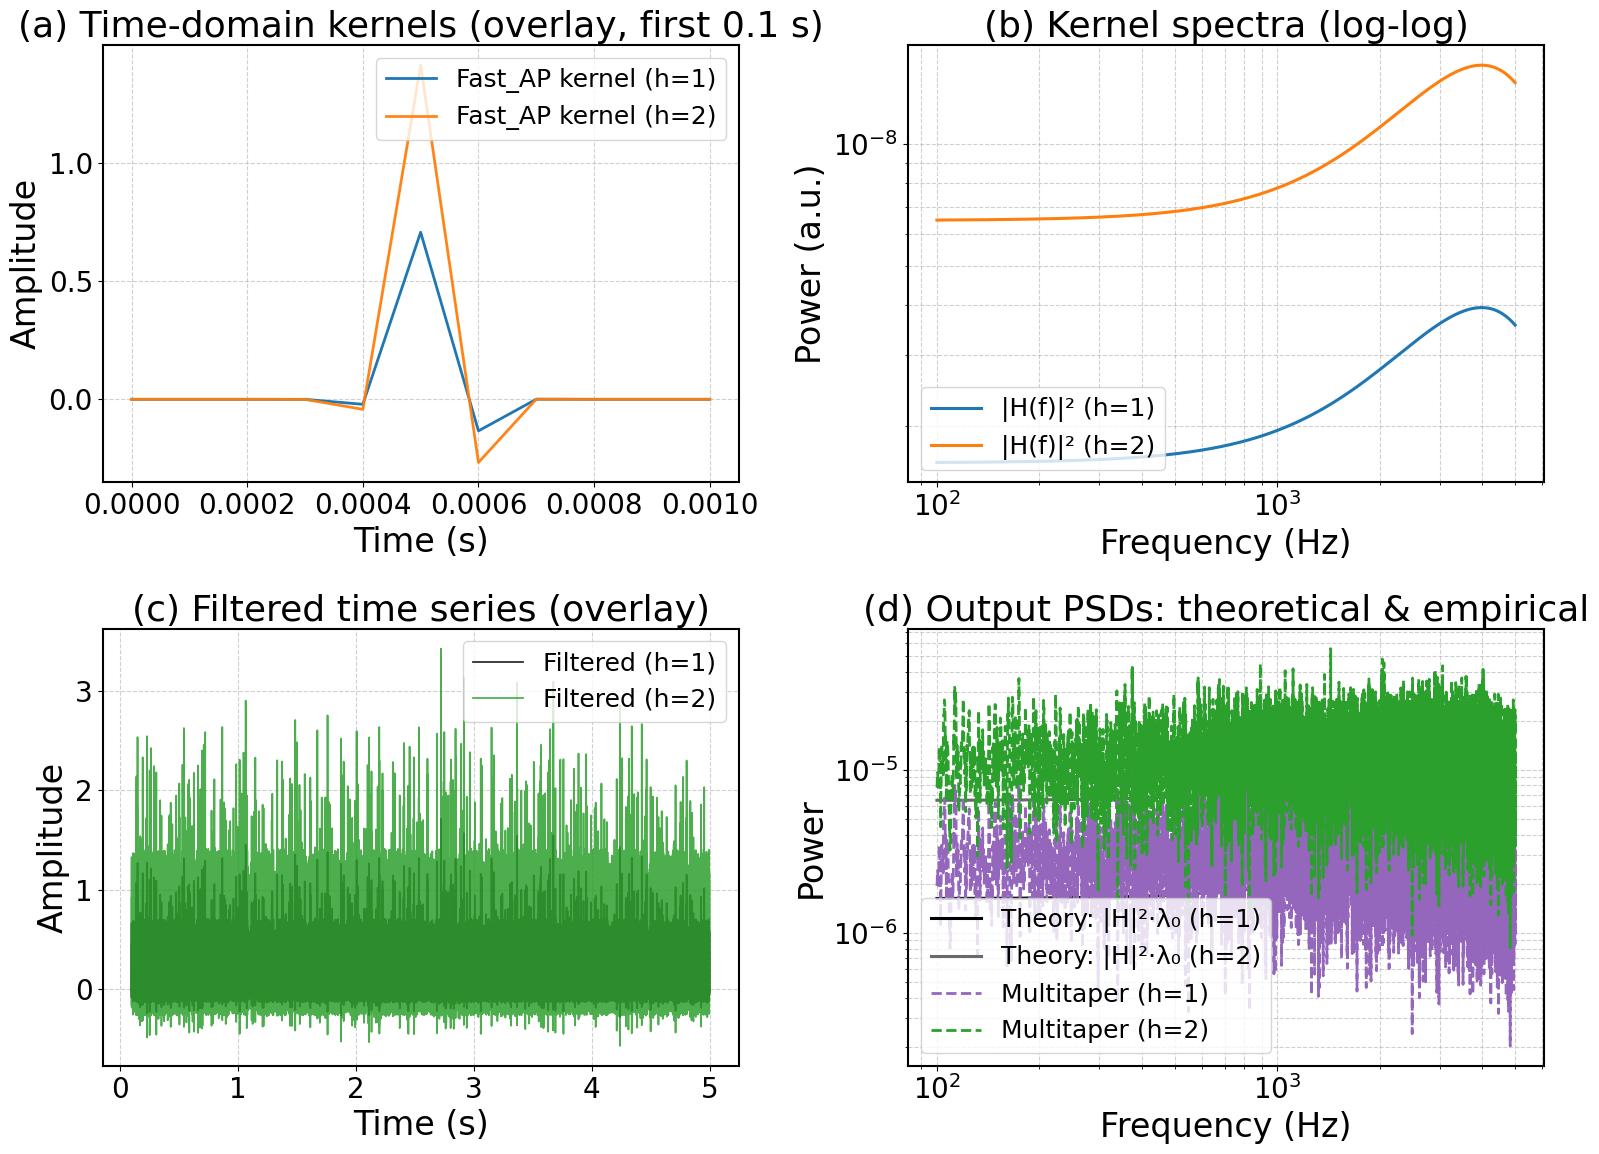

In [6]:
# --------------------- Figure: 2 rows × 2 cols ---------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax_r1c1, ax_r1c2), (ax_r2c1, ax_r2c2) = axes

# Row 1, Col 1: Kernels overlay (first 0.1 s)
ax_r1c1.plot(t1[mask_01s_1], k1[mask_01s_1], lw=2, color=kernel_h1_color, label=f'{FILTER_NAME} kernel (h=1)')
ax_r1c1.plot(t2[mask_01s_2], k2[mask_01s_2], lw=2, color=kernel_h2_color, label=f'{FILTER_NAME} kernel (h=2)', alpha=0.95)
ax_r1c1.set_title("(a) Time-domain kernels (overlay, first 0.1 s)")
ax_r1c1.set_xlabel("Time (s)")
ax_r1c1.set_ylabel("Amplitude")
ax_r1c1.grid(True)
ax_r1c1.legend(loc="upper right")

# Row 1, Col 2: Kernel power spectra |H(f)|^2 (log-log)
ax_r1c2.loglog(f_theory, H2_h1_pos, lw=2.2, color=kernel_h1_color, label="|H(f)|² (h=1)")
ax_r1c2.loglog(f_theory, H2_h2_pos, lw=2.2, color=kernel_h2_color, label="|H(f)|² (h=2)")
ax_r1c2.set_title("(b) Kernel spectra (log-log)")
ax_r1c2.set_xlabel("Frequency (Hz)")
ax_r1c2.set_ylabel("Power (a.u.)")
ax_r1c2.grid(True, which='both')
ax_r1c2.legend(loc="lower left")

# Row 2, Col 1: Filtered time series overlay
ax_r2c1.plot(time_axis, ts_h1, lw=1.25, color='k', alpha=0.85, label="Filtered (h=1)")
ax_r2c1.plot(time_axis, ts_h2, lw=1.25, color=mt_h2_color, alpha=0.85, label="Filtered (h=2)")
ax_r2c1.set_title("(c) Filtered time series (overlay)")
ax_r2c1.set_xlabel("Time (s)")
ax_r2c1.set_ylabel("Amplitude")
ax_r2c1.grid(True)
ax_r2c1.legend(loc="upper right")

# Row 2, Col 2: Output PSDs — theoretical & empirical
ax_r2c2.loglog(f_theory, S_th_h1_pos, lw=2.2, color=theory_h1_color, label="Theory: |H|²·λ₀ (h=1)")
ax_r2c2.loglog(f_theory, S_th_h2_pos, lw=2.2, color=theory_h2_color, label="Theory: |H|²·λ₀ (h=2)")
ax_r2c2.loglog(f_mt1, P_mt1, '--', lw=2.0, color=mt_h1_color, label="Multitaper (h=1)")
ax_r2c2.loglog(f_mt2, P_mt2, '--', lw=2.0, color=mt_h2_color, label="Multitaper (h=2)")
ax_r2c2.set_title("(d) Output PSDs: theoretical & empirical")
ax_r2c2.set_xlabel("Frequency (Hz)")
ax_r2c2.set_ylabel("Power")
ax_r2c2.grid(True, which='both')
ax_r2c2.legend(loc="lower left")

plt.tight_layout()
plt.show()

## Post synaptic potential scaling kernel example

In [7]:
# --------------------- Sim params ---------------------
fs = 10_000       # Hz
T = 5.0           # s
lambda_0 = 1_000  # Hz
seed = 44
model_params = {"lambda_0": lambda_0}
sim_params   = {"fs": fs, "T": T, "simulate": True, "seed": seed}
FILTER_NAME = "GABA"  # or "AMPA"

# --------------------- Build two FPPs: h=1 and h=2 ---------------------
model_h1 = Model("homogeneous_poisson", model_params, sim_params)
fpp_h1 = FilteredPointProcess(filters={FILTER_NAME: FILTER_NAME},
                              model=model_h1,
                              filter_params={FILTER_NAME: {"h": 1.0}})
fpp_h1.apply_filter_sequences([[FILTER_NAME]])

model_h2 = Model("homogeneous_poisson", model_params, sim_params)
fpp_h2 = FilteredPointProcess(filters={FILTER_NAME: FILTER_NAME},
                              model=model_h2,
                              filter_params={FILTER_NAME: {"h": 2.0}})
fpp_h2.apply_filter_sequences([[FILTER_NAME]])

# --------------------- Retrieve kernel/time/spectra ---------------------
flt1 = fpp_h1.filter_instances[FILTER_NAME]
flt2 = fpp_h2.filter_instances[FILTER_NAME]

t1 = flt1.kernel_time_axis
t2 = flt2.kernel_time_axis
k1 = flt1.kernel
k2 = flt2.kernel
mask_05s_1 = t1 <= 0.1
mask_05s_2 = t2 <= 0.1

# Filtered time series (burn-in to avoid edge effects)
burn_in = int(0.1 * fs)  # 100 ms
ts_h1 = fpp_h1.final_time_series[burn_in:]
ts_h2 = fpp_h2.final_time_series[burn_in:]
time_axis = np.linspace(0, T, len(fpp_h1.final_time_series), endpoint=False)[burn_in:]

# Kernel power spectra (|H(f)|^2) — filter-only
freqs_theory = model_h1.frequencies
H2_h1 = flt1.kernel_spectrum
H2_h2 = flt2.kernel_spectrum

# Theoretical output PSD of filtered homogeneous Poisson: S_y(f) = |H(f)|^2 * λ0
S_theory_h1 = H2_h1 * lambda_0
S_theory_h2 = H2_h2 * lambda_0


f_mt_h1, P_mt_h1 = mt_psd(ts_h1, fs, time_axis[0])
f_mt_h2, P_mt_h2 = mt_psd(ts_h2, fs, time_axis[0])

fmin, fmax = 1, 300
sel_theory = (freqs_theory >= fmin) & (freqs_theory <= fmax)
f_theory   = freqs_theory[sel_theory]
H2_h1_pos  = H2_h1[sel_theory]
H2_h2_pos  = H2_h2[sel_theory]
S_th_h1_pos = S_theory_h1[sel_theory]
S_th_h2_pos = S_theory_h2[sel_theory]

sel_mt1 = (f_mt_h1 >= fmin) & (f_mt_h1 <= fmax)
f_mt1 = f_mt_h1[sel_mt1]; P_mt1 = P_mt_h1[sel_mt1]
sel_mt2 = (f_mt_h2 >= fmin) & (f_mt_h2 <= fmax)
f_mt2 = f_mt_h2[sel_mt2]; P_mt2 = P_mt_h2[sel_mt2]




[timing] recompute filters took 0.05s
[timing] recompute filters took 0.04s


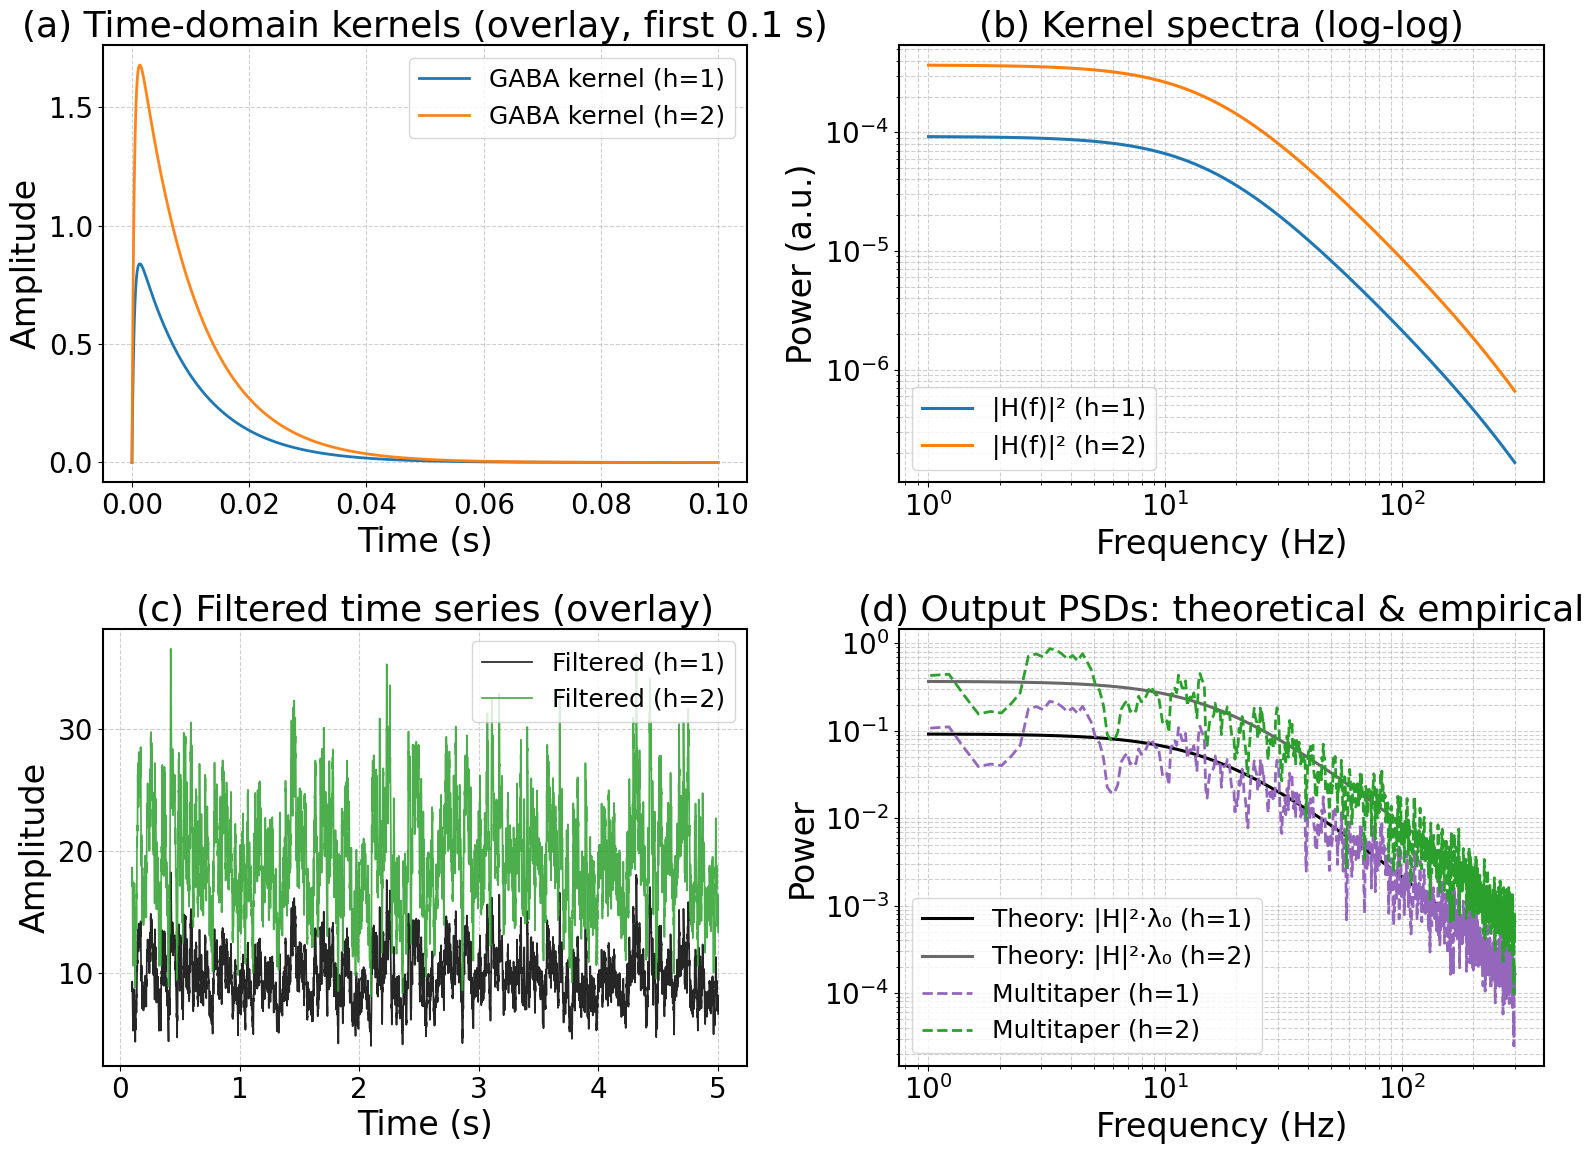

In [8]:
# --------------------- Figure: 2 rows × 2 cols ---------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax_r1c1, ax_r1c2), (ax_r2c1, ax_r2c2) = axes

# Row 1, Col 1: Kernels overlay (first 0.5 s)
ax_r1c1.plot(t1[mask_05s_1], k1[mask_05s_1], lw=2, color=kernel_h1_color, label=f'{FILTER_NAME} kernel (h=1)')
ax_r1c1.plot(t2[mask_05s_2], k2[mask_05s_2], lw=2, color=kernel_h2_color, label=f'{FILTER_NAME} kernel (h=2)', alpha=0.95)
ax_r1c1.set_title("(a) Time-domain kernels (overlay, first 0.1 s)")
ax_r1c1.set_xlabel("Time (s)")
ax_r1c1.set_ylabel("Amplitude")
ax_r1c1.grid(True)
ax_r1c1.legend(loc="upper right")

# Row 1, Col 2: Kernel power spectra |H(f)|^2 (log-log)
ax_r1c2.loglog(f_theory, H2_h1_pos, lw=2.2, color=kernel_h1_color, label="|H(f)|² (h=1)")
ax_r1c2.loglog(f_theory, H2_h2_pos, lw=2.2, color=kernel_h2_color, label="|H(f)|² (h=2)")
ax_r1c2.set_title("(b) Kernel spectra (log-log)")
ax_r1c2.set_xlabel("Frequency (Hz)")
ax_r1c2.set_ylabel("Power (a.u.)")
ax_r1c2.grid(True, which='both')
ax_r1c2.legend(loc="lower left")

# Row 2, Col 1: Filtered time series overlay
ax_r2c1.plot(time_axis, ts_h1, lw=1.25, color='k', alpha=0.85, label="Filtered (h=1)")
ax_r2c1.plot(time_axis, ts_h2, lw=1.25, color=mt_h2_color, alpha=0.85, label="Filtered (h=2)")
ax_r2c1.set_title("(c) Filtered time series (overlay)")
ax_r2c1.set_xlabel("Time (s)")
ax_r2c1.set_ylabel("Amplitude")
ax_r2c1.grid(True)
ax_r2c1.legend(loc="upper right")

# Row 2, Col 2: Output PSDs — theoretical & empirical
ax_r2c2.loglog(f_theory, S_th_h1_pos, lw=2.2, color=theory_h1_color, label="Theory: |H|²·λ₀ (h=1)")
ax_r2c2.loglog(f_theory, S_th_h2_pos, lw=2.2, color=theory_h2_color, label="Theory: |H|²·λ₀ (h=2)")
ax_r2c2.loglog(f_mt1, P_mt1, '--', lw=2.0, color=mt_h1_color, label="Multitaper (h=1)")
ax_r2c2.loglog(f_mt2, P_mt2, '--', lw=2.0, color=mt_h2_color, label="Multitaper (h=2)")
ax_r2c2.set_title("(d) Output PSDs: theoretical & empirical")
ax_r2c2.set_xlabel("Frequency (Hz)")
ax_r2c2.set_ylabel("Power")
ax_r2c2.grid(True, which='both')
ax_r2c2.legend(loc="lower left")

plt.tight_layout()
plt.show()